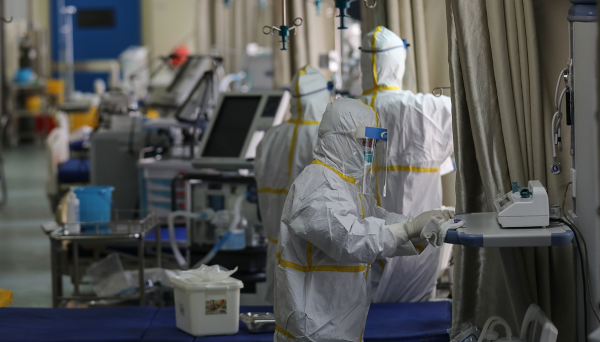

Photo Credit: STR / Getty, Source: https://wellcome.ac.uk/news/urgent-investment-needed-diagnostics-treatments-and-vaccines-end-covid-19-pandemic-coronavirus

*Medical staff disinfect equipment at an isolation ward for patients infected by COVID-19 in Wuhan, China. Ending the pandemic relies on greater investment and global coordination.
*


# Introduction

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 29,000 scholarly articles, including over 13,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.

## Dataset Description

The CORD-19 dataset represents the most extensive machine-readable coronavirus literature collection available for data mining to date. This allows the worldwide AI research community the opportunity to apply text and data mining approaches to find answers to questions within, and connect insights across, this content in support of the ongoing COVID-19 response efforts worldwide. There is a growing urgency for these approaches because of the rapid increase in coronavirus literature, making it difficult for the medical community to keep up.

This dataset was created by the Allen Institute for AI in partnership with the Chan Zuckerberg Initiative, Georgetown University’s Center for Security and Emerging Technology, Microsoft Research, and the National Library of Medicine - National Institutes of Health, in coordination with The White House Office of Science and Technology Policy.

A list of our initial key questions can be found under the Tasks section of this dataset. These key scientific questions are drawn from the NASEM’s SCIED (National Academies of Sciences, Engineering, and Medicine’s Standing Committee on Emerging Infectious Diseases and 21st Century Health Threats) research topics and the World Health Organization’s R&D Blueprint for COVID-19.

References:   
[https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge](http://)   
COVID-19 Open Research Dataset (CORD-19). 2020. Version 2020-03-13. Retrieved from https://pages.semanticscholar.org/coronavirus-research. doi:10.5281/zenodo.3715506

## Objective

The aim of this notebook is to provide resources and insights, through data science, to answer the following questions raised by the challenge proposed by Kaggle:  
*What do we know about virus genetics, origin, and evolution? 
*
## Adopted strategy

The strategy adopted in this study to obtain the most relevant information from the dataset provided was to use NLP (Natural Language Processing), more specifically n-gram of words, together with graphical resources. 

The dataset focused in this study was obtained from the biorxiv_medrxiv folder.

### N-gram teory

In the fields of computational linguistics and probability, an n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. The n-grams typically are collected from a text or speech corpus. When the items are words, n-grams may also be called shingles.  

Using Latin numerical prefixes, an n-gram of size 1 is referred to as a "unigram"; size 2 is a "bigram" (or, less commonly, a "digram"); size 3 is a "trigram". English cardinal numbers are sometimes used, e.g., "four-gram", "five-gram", and so on.

In general, ngrams sentences are generated after removing words of little textual value, known as Stop Words.
These sentences can bring synthesized information about the texts, especially when combined with filters and graphic resources.

Reference: [https://en.wikipedia.org/wiki/N-gram](http://)

# Code development for insights
First, let's import the necessary libraries.  
For our NLP development we will mainly use the NLTK library, moreover we use wordcloud, seaborn and networkx libraries for plots and graphs.

In [ ]:
import os
import json
from pprint import pprint
from copy import deepcopy
from tqdm.notebook import tqdm

from nltk.corpus import stopwords

import numpy as np
import random
import string
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import collections
from nltk.util import ngrams
import nltk
import networkx as nx
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Now we need to prepare our dataset. 
We will perform some manipulations with the files provided.

In [ ]:
# Some procedures from https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv
biorxiv_dir = '/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/'
filenames = os.listdir(biorxiv_dir)

all_files = []

for filename in filenames:
    filename = biorxiv_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)

    
print(f'Total number of files: {len(all_files)}')

In [ ]:
# Visualise the keys (columns) of the dataset
fileTest = all_files[0]
print("Dictionary keys:", fileTest.keys())

In order to avoid excess memory demand we will execute the study with just a part of the total amount of files.

In [ ]:
all_files = all_files[0:400] # Sample of the dataset for testing
print(f'Total number of files used: {len(all_files)}')

Second, we create some functions to help us in pre-processing and ploting in order to avoid repeating code snippets.

In [ ]:
# Creating some functions to help us in pre-processing and ploting

# Create function to perform pre processing
def pre_treatment_ngram(text):
    # Get the text in lower case
    text = text.lower()
    # Remove everything from our dataset except letters, and spaces
    text = re.sub(r'[^A-Za-z\d ]', '', text)
    # Clean the text with regex, remove Coprights and doi.org urls 
    text = re.sub(r'[Dd]oi:.*\.|http.*\.|International license.*\.|[Cc]opyright.*\.', '', text)
    text = re.sub(' et | el | la | il | al | li | fig\. ', '', text)
    text = re.sub('[Mm]edrxiv.*\.|[Ll]icence.*\.', '', text) 
    # Tokenization
    words_tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stoplist = stopwords.words('english')
    clean_word_list = [word for word in words_tokens if word not in stoplist]
    return clean_word_list


# Create function do help plot world cloud
def print_word_cloud(dictionary):
    # Convert to string and send to wordcloud
    textNgram = str(dictionary)
    # Clean words
    textNgram = re.sub('[\']', '', textNgram)
    # Send to wordcloud
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(textNgram)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

# Function to create graph of conections
# Thanks to https://www.earthdatascience.org/courses/earth-analytics-python/using-apis-natural-language-processing-twitter/calculate-tweet-word-bigrams-networks-in-python/
def create_graph_conections(importantWord):
    # Create dictionary of bigrams and their counts
    d = ngramsList_df.set_index('n-gram').T.to_dict('records')
    # Create network plot 
    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    G.add_node(importantWord, weight=100)
    fig, ax = plt.subplots(figsize=(20, 15))

    pos = nx.spring_layout(G, k=1)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=16,
                     width=3,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)
    
    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.135, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=13)
    plt.show()

## Analyzing file texts
In order to analyze the texts of the articles without distinction, we created a unique body of text, using the code below.


In [ ]:
# Creating a body text from dataset files
# Some procedures from https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv

textFromFile = 'body_text'

body = ""
for file in all_files:
    try:
        # Reading the text body from file
        texts = [(di['section'], di['text']) for di in file[textFromFile]]
        texts_di = {di['section']: "" for di in file[textFromFile]}
        for section, text in texts:
            texts_di[section] += text
        
        for section, text in texts_di.items():
            body += section
            body += text

        # Clean the text with regex, remove Coprights and doi.org urls 
        body = re.sub(r'[Dd]oi:.*\.|http.*\.|International license.*\.|[Cc]opyright.*\.', '', body)
        body = re.sub(' et | el | la | il | al | li | fig\. ', '', body)
        body = re.sub('[Mm]edr.*\.', '', body)        
    except: 
        continue
    

print(f'Total number of characters, from {textFromFile} of the files:')
print(len(body))


In [ ]:
# Performing pre-treatment using the created function
clean_word_list = pre_treatment_ngram(body)
print(f'Total number of filtered words, from {textFromFile} of the files:')
print(len(clean_word_list))
# print(clean_word_list)

### Creating and accessing ngrams

In this study we consider a tetra-gram (sequence of 4 words) as default ngram.
If necessary one can change it, just changing the value of the variable 'wordChain'.
In this step, we create the ngram sequence.   
After that, we evaluate the results looking for insights. For this, visual analyzes were made through graphics, as well as based on readings of the obtained word sequences.

### Viewing Networks of ngrams

In order to facilitate the understanding of the words interconnections  obtained in ngrams, we will use network graphics. The words represented by points are connected by the lines there.

Reference: https://www.earthdatascience.org/courses/earth-analytics-python/using-apis-natural-language-processing-twitter/calculate-tweet-word-bigrams-networks-in-python/

In [ ]:
# Define de ngram
wordChain = 4
ngramsList = ngrams(clean_word_list, wordChain)
result = collections.Counter(ngramsList)

# Convert to dataframe
ngramsList_df = pd.DataFrame(result.most_common(100),
                             columns=['n-gram', 'count'])



# ngram = ngramsList_df['n-gram']
# y_pos = np.arange(len(ngram))
# counts = ngramsList_df['count']


# plt.figure(figsize=(9,11))
# sns.barplot(x=counts,y=ngram)

In [ ]:
# Define de ngram
wordChain = 4

# Define list of important words
importantWords = ['origin', 'COVID',
                  'coronavirus', 'evolution', 'genetics']

for word in importantWords:
    print(f'Network graphic related to the word "{word}"')
    create_graph_conections(word)    

### Creating a word cloud with important words

First, we create an unfiltered word cloud.   
After that, we create an n-gram based word cloud that contains a list of important words.

In this step, we generate the tetra-gram dictionary considering the entire text.

Reference: https://stackabuse.com/python-for-nlp-developing-an-automatic-text-filler-using-n-grams/

In [ ]:
dictNgrams = {}
# Creating a dictionary of ngram
# Thanks for https://stackabuse.com/python-for-nlp-developing-an-automatic-text-filler-using-n-grams/

for i in range(len(clean_word_list)-wordChain):
    seq = ' '.join(clean_word_list[i:i+wordChain])
    if  seq not in dictNgrams.keys():
        dictNgrams[seq] = []
        dictNgrams[seq].append(clean_word_list[i+wordChain])
        
print('Some sentences of ngrams:\n')
for x in list(dictNgrams)[0:20]:
    print (x)

After, we print the unfiltered word cloud.

In [ ]:
print_word_cloud(dictNgrams)

Here, we generate a dictionary with the tetra-grams that contains a list of important words.   
This dictionary will help us to filter and focus our search domain on a group of relevant words.

In [ ]:
# List of important words for filtering our sentences
importantWords = ['origin', 'virus', 'transmission', 'COVID',
                  'coronavirus', 'evolution', 'genetics', 'glycoprotein']
dictNgrams = {}
# Thanks for https://stackabuse.com/python-for-nlp-developing-an-automatic-text-filler-using-n-grams/
for i in range(len(clean_word_list)-wordChain):
    seq = ' '.join(clean_word_list[i:i+wordChain])
    for w in importantWords:
         if w in seq:
#             print(seq)
            if  seq not in dictNgrams.keys():
                dictNgrams[seq] = []
                dictNgrams[seq].append(clean_word_list[i+wordChain])
                

# print top keys
k = collections.Counter(dictNgrams) 
  
# Finding 600 values 
high = k.most_common(30)  

print(' Some sentences of ngrams with important words:\n')
print("Keys: Values\n") 
  
for i in high: 
    print(i[0]," :",i[1]," ") 


Now, as we said earlier, we generate the word cloud with sentences generated from the list of important words.

In [ ]:
print('Word cloud from ngrams sentences with important words:\n')

print_word_cloud(dictNgrams)

# Discussion

### Answering the question of the task:  
### What do we know about virus genetics, origin, and evolution?

From reading the sentences of tetra-gram returned by the proposed algorithm, we can verify that some of them provide important information about genetics, origin, and evolution.

Below we select some of these sentences tha we found for contextualization:

*high similarity bat coronaviruses   
coronaviruses outbreaks health care   
ancestor gorbalenya 2006 nidoviruses   
china suggesting animaltoperson transmission   
dependence satellite viruses helper  
virus protein mediates fusion  
cellular membranescoronaviruses bind cell  
replicase protein suggest nidoviruses  
viruscell fusion entry mechanisms  
similar dependence satellite viruses 

Note: Due to the certain randomness in the selection of the most important sentences, some of these phrases     may not appear in a certain round, but similar ones should appear.   *

Based on these senteces we can assume that Coronavirus:   
**It has similarity with bat coronavirus and may have migrated from animal to person.   
Enzyme replicase indicates a probable relationship with nidoviruses. 
It resembles satellite viruses.
**   
Note: It is clear that all these assertions must be evaluated by an expert with the aim of validation or not.

The graphics of the word networks provide us, in a simple and agile way, information about the interconnection of important words. Much of the information obtained there corroborates with the conclusions proposed above.

The generated word clouds provide us with visual information for the main search terms very quickly.


# Conclusion

In this notebook we present a methodology based on the ngrams technique to analyse the documents provided in search of relevant information.   
Tetra-gram sentences were obtained and graphs and word clouds were plotted.   
The results show that the technique can be used to gain important insights into the coronavirus pandemic, in an agile way and without having to read thousands of full papers.
The same procedure can be used to study any topic, just by changing the list of relevant words.  
 
## Pros and cons

About the technique used, we can highlight the ease and speed of obtaining the results.   
As cons, we emphasize that it is not a fully automated analysis technique since it requires a certain work by the user.


### I hope you enjoyed!
### Lovingly from Brazil to help the world fight the pandemic.
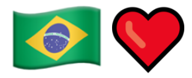